# Import de fonctions

In [1]:
import sys
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import v_measure_score
import datetime

# Dataset des chiffres du MNIST
from keras.datasets import mnist
from skimage.transform import resize

# import UCSL github : Unsupervised Clustering driven by Supervised Learning 
!git clone https://github.com/rlouiset/py_ucsl > /dev/null 2>&1

sys.path.append('./py_ucsl/')
from ucsl.ucsl_classifier import *
from ucsl.ucsl_regressor import *

In [2]:
colors = np.array(list(['#377eb8', '#ff7f00', '#4daf4a',
                        '#f781bf', '#a65628', '#984ea3',
                        '#999999', '#e41a1c', '#dede00']))

# Fonction pour afficher les données matricielles sous forme d'images
def display_image(X, y, n, label=False):
    dim = 32
    fig, axs = plt.subplots(n, n, figsize=(5,5))

    for i in range(n):
      for j in range(n):
        axs[i,j].imshow(X[j*n+i].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')
    plt.show()

In [3]:
# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_ground_truth = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

# Train an auto encoder

11493376/11490434 [==============================] - 0s 0us/step
torch.Size([128, 1, 32, 32])


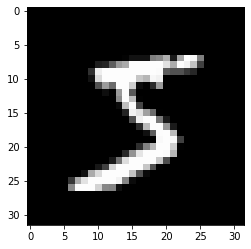

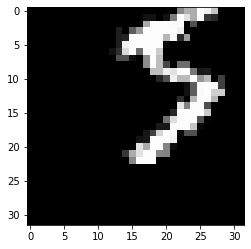

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import grey_erosion, grey_dilation
import torchvision.models as models


# Dataset des chiffres du MNIST
from keras.datasets import mnist
from skimage.transform import resize

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([np.pad(img, 2) for img in X_train])
X_test= np.array([np.pad(img, 2) for img in X_test])
X_train = X_train[:20000]
y_train = y_train[:20000]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)


class Erode(object):
    """Random erode transform"""
    def __init__(self, kernel):
        self.kernel = kernel
    def __call__(self, x):
        x = grey_erosion(x, size=(self.kernel, self.kernel))
        return x
  
class Dilate(object):
    """Random dilate transform"""
    def __init__(self, kernel):
        self.kernel = kernel

    def __call__(self, x):
        x = grey_dilation(x, size=(self.kernel, self.kernel))
        return x

# how many samples per batch to load
batch_size = 128

class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = torch.from_numpy(target).double()
        self.transform = transforms.Compose([
                            #transforms.RandomApply([Erode(2)], p=0.33),
                            #transforms.RandomApply([Dilate(3)], p=0.33),
                            transforms.ToTensor(),
                            transforms.RandomRotation(40),
                            transforms.RandomAffine(25, translate=(0.2, 0.2), shear=0.45)
                        ])
     
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index):
        x = self.data[index]
        x = np.reshape(x, (32, 32))
        transformed_x = self.transform(x)
        x = torch.tensor(x[None,:,:]).double()
        y = self.target[index]

        return x.cuda(), transformed_x.cuda(), y.cuda()

# load the training and test datasets
train_data = MyDataset(X_train, y_train)
test_data = MyDataset(X_test, y_test)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

dataiter = iter(train_loader)
images, transformed_images, labels = dataiter.next()

print(images.shape)
plt.imshow(images[0][0].cpu().numpy(), cmap='gray')
plt.show()

plt.imshow(transformed_images[0][0].cpu().numpy(), cmap='gray')
plt.show()

In [5]:
# Encoder model
class EncoderNetwork(nn.Module):
    def __init__(self, ndf, nz, nc):
        super(EncoderNetwork, self).__init__()
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=True)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=True)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, nz, 4, 2, 1, bias=True)
        self.avgpool = nn.AvgPool2d(2)

    def forward(self, x):
        # input is (nc) x 32 x 32
        h1 = nn.LeakyReLU(0.2, inplace=True)(self.conv1(x))
        h2 = nn.LeakyReLU(0.2, inplace=True)(self.bn2(self.conv2(h1)))
        h3 = nn.LeakyReLU(0.2, inplace=True)(self.bn3(self.conv3(h2)))
        output = self.avgpool(self.conv4(h3))

        return output

# Generator model
class GeneratorNetwork(nn.Module):
    def __init__(self, ngf, nz, nc):
        super(GeneratorNetwork, self).__init__()
        self.convT1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=True)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.convT2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.convT3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=True)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.convT4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.conv = nn.Conv2d(ngf, nc, 1, bias=True)

    def forward(self, x):
        # input is Z, going into a convolution
        h1 = nn.ReLU(True)(self.bn1(self.convT1(x)))
        # state size. (ngf*8) x 4 x 4
        h2 = nn.ReLU(True)(self.bn2(self.convT2(h1)))
        # state size. (ngf*4) x 8 x 8
        h3 = nn.ReLU(True)(self.bn3(self.convT3(h2)))
        # state size. (ngf*2) x 16 x 16
        h4 = nn.ReLU(True)(self.bn4(self.convT4(h3)))
        # state size. (ngf) x 32 x 32
        output = nn.Tanh()(self.conv(h4))
        return output


class LinearCritic(nn.Module):
    def __init__(self, latent_dim, temperature=1.):
        super(LinearCritic, self).__init__()
        self.temperature = temperature
        self.projection_dim = 128
        self.w1 = nn.Linear(latent_dim, latent_dim, bias=False)
        self.bn1 = nn.BatchNorm1d(latent_dim)
        self.relu = nn.ReLU()
        self.w2 = nn.Linear(latent_dim, self.projection_dim, bias=False)
        self.bn2 = nn.BatchNorm1d(self.projection_dim, affine=False)
        self.cossim = nn.CosineSimilarity(dim=-1)

    def project(self, h):
        return self.bn2(self.w2(self.relu(self.bn1(self.w1(h)))))

    def forward(self, h1, h2):
        z1, z2 = self.project(h1), self.project(h2)
        sim11 = self.cossim(z1.unsqueeze(-2), z1.unsqueeze(-3)) / self.temperature
        sim22 = self.cossim(z2.unsqueeze(-2), z2.unsqueeze(-3)) / self.temperature
        sim12 = self.cossim(z1.unsqueeze(-2), z2.unsqueeze(-3)) / self.temperature
        d = sim12.shape[-1]
        sim11[..., range(d), range(d)] = float('-inf')
        sim22[..., range(d), range(d)] = float('-inf')
        raw_scores1 = torch.cat([sim12, sim11], dim=-1)
        raw_scores2 = torch.cat([sim22, sim12.transpose(-1, -2)], dim=-1)
        raw_scores = torch.cat([raw_scores1, raw_scores2], dim=-2)
        targets = torch.arange(2 * d, dtype=torch.long, device=raw_scores.device)
        return raw_scores, targets

# build models
nz = 32
ngf = 64
ndf = 64
nc = 1
ENet_model = EncoderNetwork(ndf, nz, nc).double().cuda()
GNet_model = GeneratorNetwork(ngf, nz, nc).double().cuda()

print(ENet_model)
print(GNet_model)

EncoderNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
GeneratorNetwork(
  (convT1): ConvTranspose2d(32, 512, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), 

### Auto-Encoder

In [ ]:
# number of epochs to train the model
n_epochs = 20

# specify loss function
list_of_parameters = []
list_of_parameters.extend(ENet_model.parameters())
list_of_parameters.extend(GNet_model.parameters())
optimizer = torch.optim.Adam(list_of_parameters, lr=0.001)

# specify loss function
criterion = nn.SmoothL1Loss()

train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here no need to flatten images
        images, _, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        latent_vectors = ENet_model.forward(images)
        outputs = GNet_model.forward(latent_vectors)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    ###################
    # evaluate the model #
    ###################
    with torch.no_grad():
      for data in test_loader:
          # _ stands in for labels, here no need to flatten images
          images, _, _ = data
          # forward pass: compute predicted outputs by passing inputs to the model
          latent_vectors = ENet_model.forward(images)
          outputs = GNet_model.forward(latent_vectors)
          # calculate the loss
          test_loss_i = criterion(outputs, images)
          # update running training loss
          test_loss += test_loss_i.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)
    #
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('         \tTesting Loss: {:.6f}'.format(
        test_loss
        ))
    
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

scaler = StandardScaler()

# transform features
X_test_latent = []
for img in X_test :
  img = img.reshape((32, 32))
  img = torch.tensor(img).cuda().double()[None, None,:,:]
  #img = img.repeat(1, 3, 1, 1)
  latent_vectors = ENet_model.forward(img)[0,:,0,0]
  X_test_latent.append(latent_vectors.cpu().detach().numpy())
X_test_latent = np.array(X_test_latent)
X_test_latent = X_test_latent.reshape((len(X_test_latent), nz))
X_test_latent = scaler.fit_transform(X_test_latent)

# transform features
X_train_latent = []
for img in X_train :
  img = img.reshape((32, 32))
  img = torch.tensor(img).cuda().double()[None, None,:,:]
  #img = img.repeat(1, 3, 1, 1)
  latent_vectors = ENet_model.forward(img)[0,:,0,0]
  X_train_latent.append(latent_vectors.cpu().detach().numpy())
X_train_latent = np.array(X_train_latent)
X_train_latent = X_train_latent.reshape((len(X_train_latent), nz))
X_train_latent = scaler.fit_transform(X_train_latent)

#
pos_label = 7
positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i in [pos_label]])
test_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_test) if y_i in [pos_label]])
X_train_pos = X_train_latent[positive_labels_indices]
X_test_pos = X_test_latent[test_positive_labels_indices]

# GMM training
GMM_method = GaussianMixture(n_components=2)
GMM_method.fit(X_train_pos)
y_pred = GMM_method.predict(X_test_pos)
print("Cluster 0 number of samples : ", np.sum(y_pred==0))
print("Cluster 1 number of samples : ", np.sum(y_pred==1))
print("GM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
print("GM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
print("GM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))


### Plot

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ENet_model))
print(count_parameters(GNet_model))

788704
3017601


Original MNIST images :


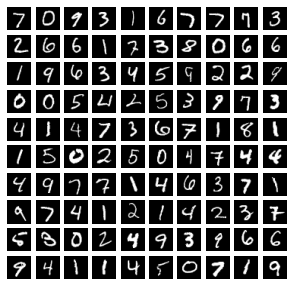

------------------------
Reconstructed MNIST images :


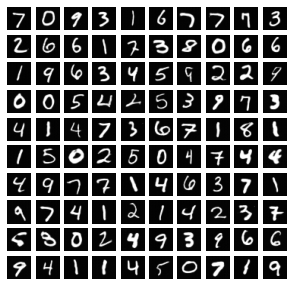

In [ ]:
dataiter = iter(test_loader)
images, _, labels = dataiter.next()

latent_vectors = ENet_model.forward(images)
outputs = GNet_model.forward(latent_vectors)


images = images[:,0,:,:].cpu().detach().numpy()
outputs = outputs[:,0,:,:].cpu().detach().numpy()

print("Original MNIST images :")
display_image(images, labels, 10, label=False)
print("------------------------")
print("Reconstructed MNIST images :")
display_image(outputs, labels, 10, label=False)

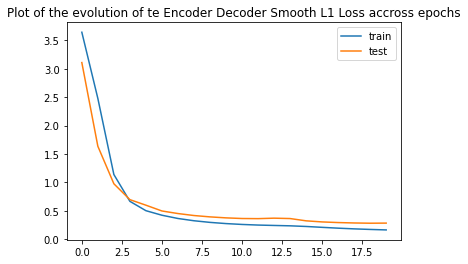

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.title("Plot of the evolution of te Encoder Decoder Smooth L1 Loss accross epochs")
plt.show()